In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_data=pd.read_csv("messy_fintech_loan_dataset.csv")

In [3]:
print("Shape:", raw_data.shape)
print("\n ---Data Info ---")
print(raw_data.info())
print("\n Missing values")
print(raw_data.isnull().sum())
print("\n --summary statistics--")
print(raw_data.describe())

Shape: (205, 8)

 ---Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Monthly_Income       186 non-null    float64
 1   Transaction_Amount   205 non-null    int64  
 2   Account_Age_Months   205 non-null    int64  
 3   Loan_History_Length  205 non-null    int64  
 4   Num_Defaults         205 non-null    int64  
 5   Credit_Score         184 non-null    float64
 6   Loan_Approved        205 non-null    int64  
 7   Loan_Type            205 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 12.9+ KB
None

 Missing values
Monthly_Income         19
Transaction_Amount      0
Account_Age_Months      0
Loan_History_Length     0
Num_Defaults            0
Credit_Score           21
Loan_Approved           0
Loan_Type               0
dtype: int64

 --summary statistics--
       Monthly_Income  Transac

In [4]:
#rhandling the missing values
#We are checking the total number of rows removed if we choose to remove rows with missing values

missing_records=raw_data[raw_data['Monthly_Income'].isna() | raw_data['Credit_Score'].isna()]
print(f"records to be removed if We choose to remove missing rows is : {missing_records.shape[0]}")

records to be removed if We choose to remove missing rows is : 39


In [5]:
#So this is not a good Idea to remove 39 rows from a dataset of 205 rows ,39 rows are really significant amount of rows

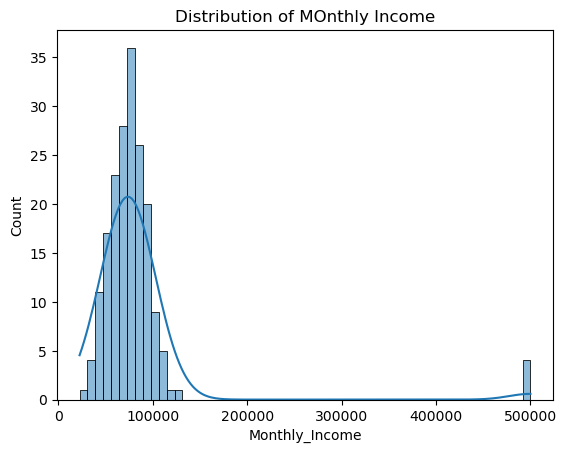

In [6]:
#So we can plan fo imputation by Mean or Median or mode 
#if symmetrical we can choose mean, if we have more skewnes and outliers we will choose median
#and mode can be choosed only for categorical data
sns.histplot(raw_data['Monthly_Income'],kde=True)
plt.title("Distribution of MOnthly Income")
plt.show()

In [7]:
#it is right skewed, so we can use median here
median_monthly_income=raw_data['Monthly_Income'].median()
raw_data['Monthly_Income'] = raw_data['Monthly_Income'].fillna(median_monthly_income)

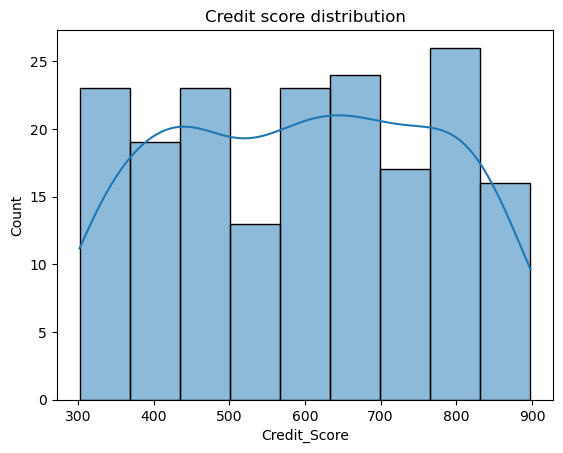

In [8]:
#similarly checking credit score
sns.histplot(raw_data['Credit_Score'],kde=True)
plt.title('Credit score distribution')
plt.show()

In [9]:
#The credit score is roughly a bell shaped cure and is normally distributed 
#so we can choose the mean imputation here

Mean_credit=raw_data['Credit_Score'].mean()
raw_data['Credit_Score'] = raw_data['Credit_Score'].fillna(Mean_credit)

In [10]:
#checking the imputation
print(raw_data.isnull().sum())

Monthly_Income         0
Transaction_Amount     0
Account_Age_Months     0
Loan_History_Length    0
Num_Defaults           0
Credit_Score           0
Loan_Approved          0
Loan_Type              0
dtype: int64


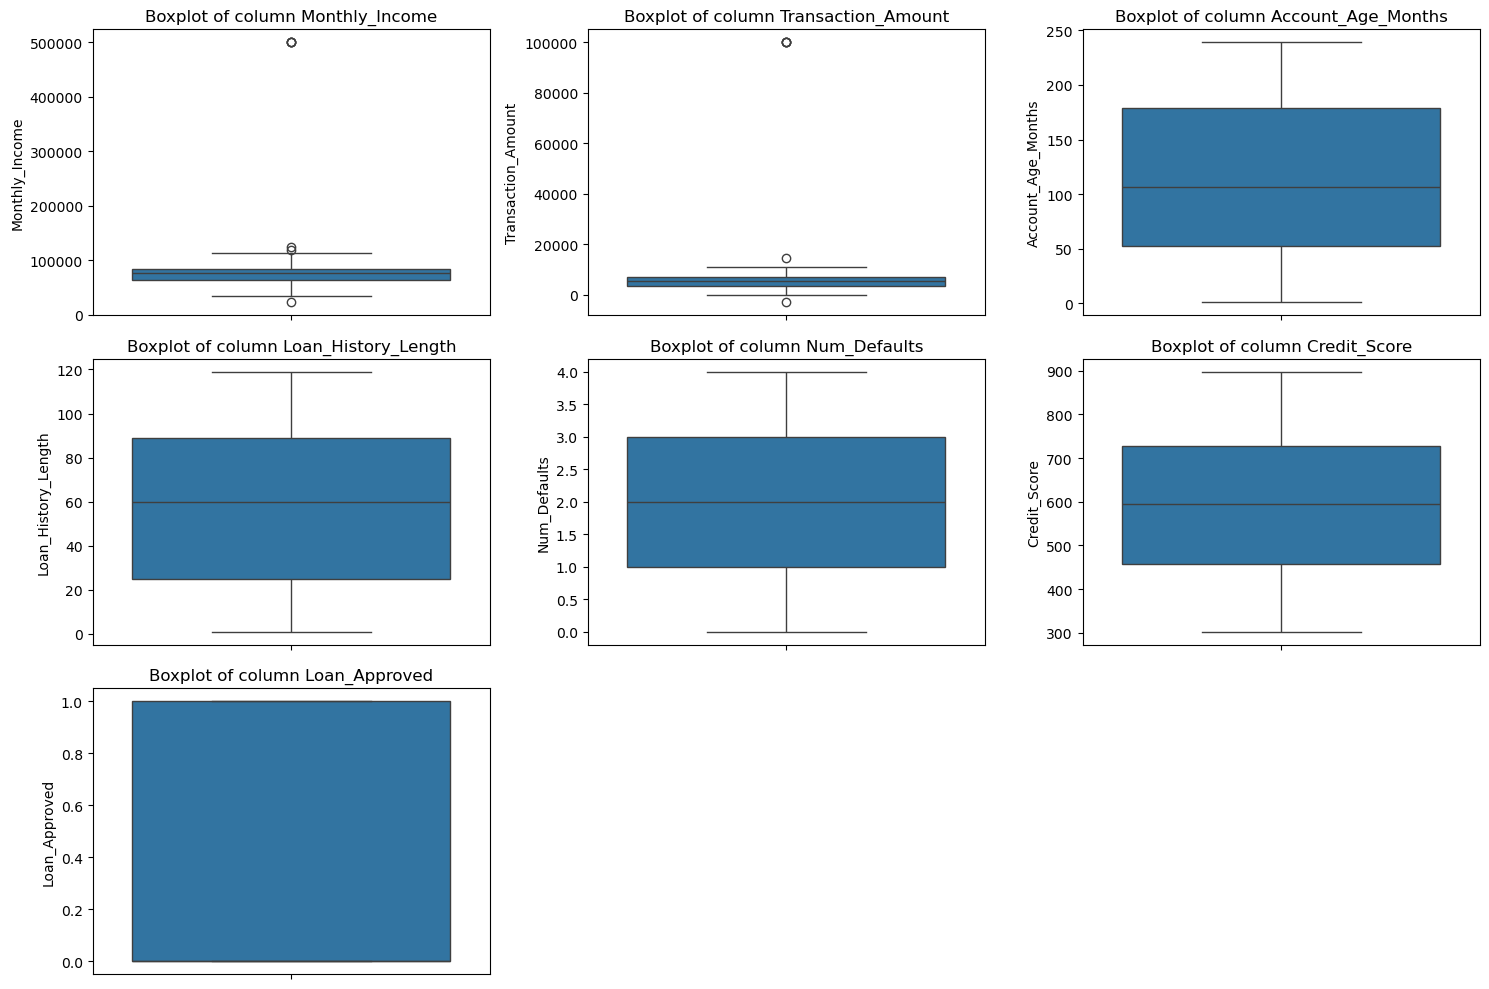

In [46]:
#now we have to detect the  outliers , using boxplot for each numerical parameter.

plt.figure(figsize=(15,10))
for i, column in enumerate (raw_data.select_dtypes(include='number').columns,1):
    plt.subplot(3,3,i)
    sns.boxplot(y=raw_data[column])
    plt.title(f'Boxplot of column {column}')
plt.tight_layout()
plt.show()

In [98]:
#to remove the outliers on monthly_income
#As Loan approved is the target we don't need to add them to our 
raw_data_copy = raw_data.copy()
num_columns = raw_data_copy.select_dtypes(include='number').columns.drop('Loan_Approved', errors='ignore')

# Initialize a mask for non-outliers (all True)
non_outlier_mask = pd.Series(True, index=raw_data_copy.index)

for col in num_columns:
    q1 = raw_data_copy[col].quantile(0.25)
    q3 = raw_data_copy[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    col_mask = (raw_data_copy[col] >= lower) & (raw_data_copy[col] <= upper)
    non_outlier_mask &= col_mask  # Combine mask using AND

# Final cleaned dataset
outlier_free_data = raw_data_copy[non_outlier_mask]

print(f"Original data shape: {raw_data.shape}")
print(f"Cleaned data shape: {outlier_free_data.shape}")
    


Original data shape: (205, 8)
Cleaned data shape: (192, 8)


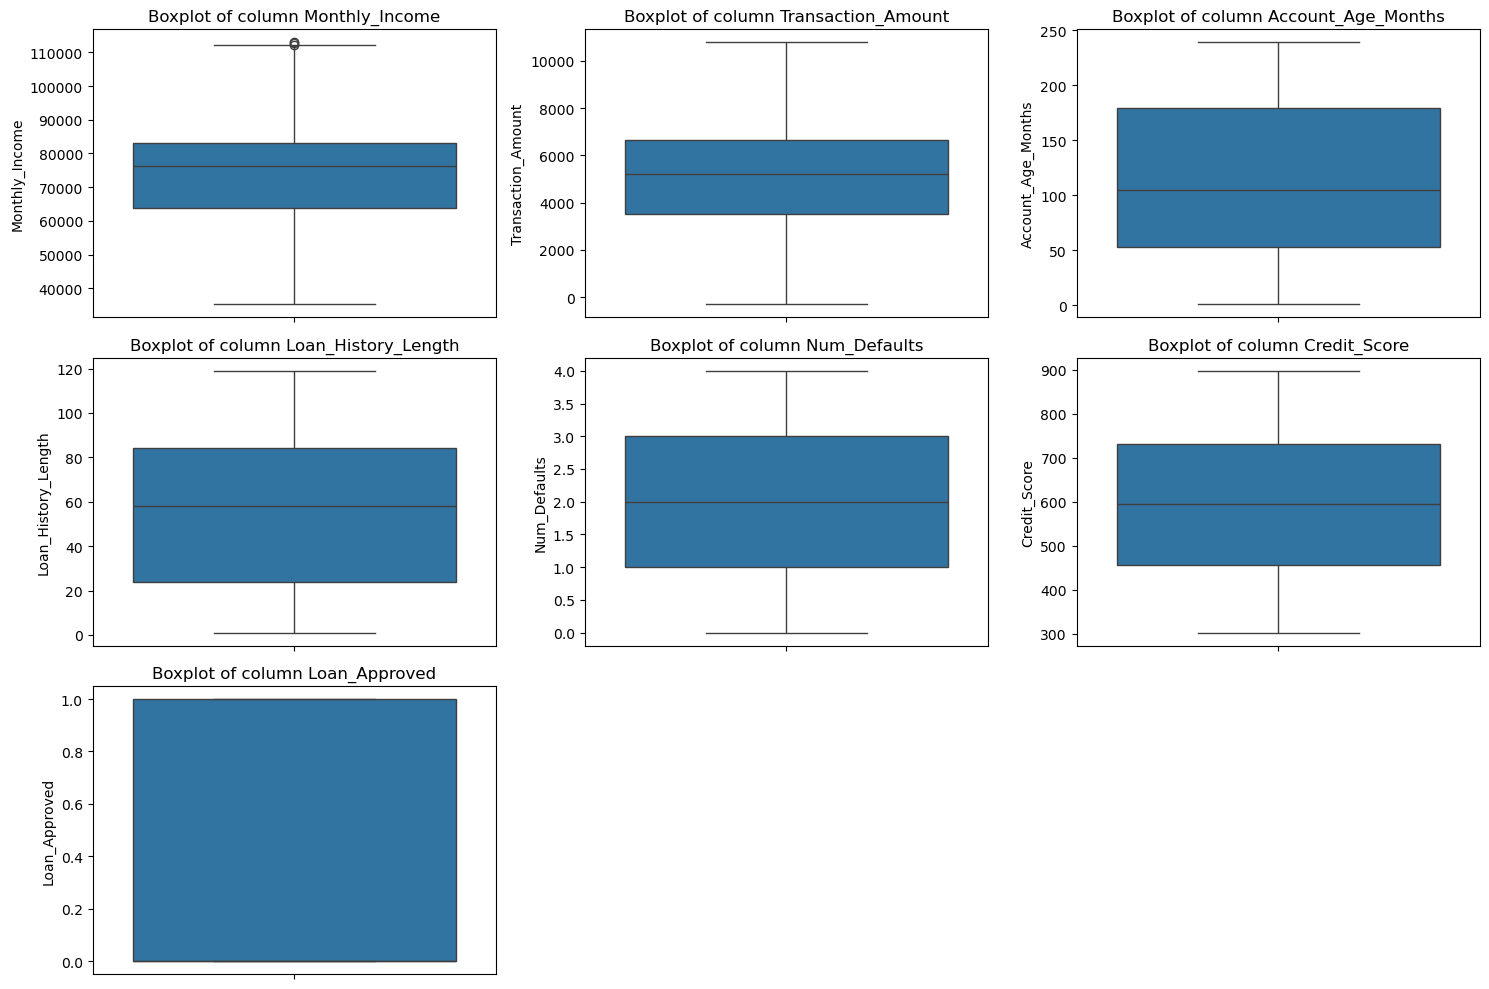

In [104]:
#lets visualize the new boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(outlier_free_data.select_dtypes(include='number').columns, 1):
    if i > 9: break
    plt.subplot(3, 3, i)
    sns.boxplot(y=outlier_free_data[col])
    plt.title(f'Boxplot of column {col}')

plt.tight_layout()
plt.show()

In [106]:
print("Shape of outlier_free_data:", outlier_free_data.shape)
print("Columns:", outlier_free_data.select_dtypes(include='number').columns.tolist())

Shape of outlier_free_data: (192, 8)
Columns: ['Monthly_Income', 'Transaction_Amount', 'Account_Age_Months', 'Loan_History_Length', 'Num_Defaults', 'Credit_Score', 'Loan_Approved']


In [110]:
#now we can move to encode categorical variables
outlier_free_data.select_dtypes(include='object').columns


Index(['Loan_Type'], dtype='object')

In [116]:
#lets see how many unique values are available for loan_type
print("unique loan type in the cleaned dataset :", outlier_free_data['Loan_Type'].nunique())

unique loan type in the cleaned dataset : 7


In [140]:
#applying one hor encoding on loan_type
if 'Loan_Type' in outlier_free_data.columns:
    outlier_free_data=pd.get_dummies(outlier_free_data, columns=['Loan_Type'],drop_first=True)


In [136]:
print(outlier_free_data.columns)

Index(['Monthly_Income', 'Transaction_Amount', 'Account_Age_Months',
       'Loan_History_Length', 'Num_Defaults', 'Credit_Score', 'Loan_Approved',
       'Loan_Type_Auto', 'Loan_Type_Business', 'Loan_Type_Personal',
       'Loan_Type_auto', 'Loan_Type_business', 'Loan_Type_personal'],
      dtype='object')


In [158]:
#we can scale the data now
from sklearn.preprocessing import StandardScaler

features_to_scale=outlier_free_data.drop('Loan_Approved',axis=1)
scaler=StandardScaler()
Scaled_features=scaler.fit_transform(features_to_scale)
scaled_df=pd.DataFrame(Scaled_features,columns=features_to_scale.columns)
#we need to reattach the Loan_approved column now 
final_data=pd.concat([scaled_df,outlier_free_data['Loan_Approved'].reset_index(drop=True)],axis=1)

In [ ]:
print("cleaned Shape:", final_data.shape)
print("\n ---cleaned Data Info ---")
print(final_data.info())
print("\n cleaned Missing values")
print(final_data.isnull().sum())
print("\n --cleaned summary statistics--")
print(final_data.describe())

In [285]:
#as the model did not performed well we just add new synthetic data upto 1000.
# Check current size
print("Original data shape:", final_data.shape)

# Desired size
desired_rows = 1000
current_rows = final_data.shape[0]

# How many more rows to add
rows_to_add = desired_rows - current_rows

# Resample (with replacement) from existing rows
synthetic_data = final_data.sample(n=rows_to_add, replace=True, random_state=42)

# Concatenate original and synthetic data
expanded_data = pd.concat([final_data, synthetic_data], ignore_index=True)

# Final shape
print("Expanded data shape:", expanded_data.shape)

Original data shape: (192, 13)
Expanded data shape: (1000, 13)


In [319]:
#Feature engineering to imrove the model
expanded_data['Credit_Utilization'] = expanded_data['Transaction_Amount'] / (expanded_data['Monthly_Income'] + 1)
#this feture addtion doesn't make any significant improvement in the model let's add another one now 
expanded_data['CreditScore_per_History'] = expanded_data['Credit_Score'] / (expanded_data['Loan_History_Length'] + 1)




In [343]:
#now we can do the logistic regression
from sklearn.model_selection import train_test_split
x=expanded_data.drop('Loan_Approved',axis=1)
y=expanded_data['Loan_Approved']

#split to train and test set
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.2, random_state=42)

In [345]:
#Train the logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression()

In [347]:
#make predictions
y_pred=log_reg.predict(x_test)

In [349]:
#Evaluate the model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,roc_auc_score


In [351]:
print("Accuracy:", accuracy_score(y_test,y_pred))
print("precision:", precision_score(y_test,y_pred))
print("recall_score:", recall_score(y_test,y_pred))
print("f1_score:",f1_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.57
precision: 0.5844155844155844
recall_score: 0.45454545454545453
f1_score: 0.5113636363636364
              precision    recall  f1-score   support

           0       0.56      0.68      0.62       101
           1       0.58      0.45      0.51        99

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.56       200
weighted avg       0.57      0.57      0.56       200


Confusion Matrix:
[[69 32]
 [54 45]]


In [353]:
y_pred_proba = log_reg.predict_proba(x_test)[:, 1]  # For ROC AUC
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

ROC AUC Score: 0.6531653165316532
